In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import torch
import nglview as nv
import os
import esm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from Bio.PDB import PDBParser, PDBIO, StructureBuilder
import numpy as np
from scipy.spatial.distance import pdist, squareform


In [2]:
def read_fasta(file_path):
    """Reads a single-sequence FASTA file and returns the sequence."""
    with open(file_path, 'r') as fasta_file:
        for record in SeqIO.parse(fasta_file, 'fasta'):
            return str(record.seq), record.id

fasta_path = "data/rcsb_pdb_8F0Y.fasta"  # Replace with your FASTA file path
sequence, sequence_id = read_fasta(fasta_path)
print(f"Sequence ID: {sequence_id}\nSequence: {sequence}")

Sequence ID: 8F0Y_1|Chain
Sequence: KEPCPPENLQLTPRALVGKWYLRTTSPDIFKQVSNITEFYSAHGNDYYGTVTDYSPEYGLEAHRVNLTVSGRTLKFYMNDTHEYDSKYEILAVDKDYFIFYGHPPAAPSGLALIHYRQSCPKEDVIKRVKKALKNVCLDYKYFGNDTSVPCHYVE


In [3]:
helix_formers = {'A', 'L', 'M', 'E', 'Q', 'K', 'R', 'H'}
sheet_formers = {'V', 'I', 'Y', 'F', 'C', 'T', 'W', 'N', 'S'}
helix_breakers = {'P', 'G','D'}

In [4]:
def predict_secondary_structure(fasta_sequence):
    """
    Predicts secondary structure (helix, sheet, coil) from a FASTA sequence
    using basic chemical properties.
    """
    secondary_structure = []
    
    for residue in fasta_sequence:
        if residue in helix_formers:
            secondary_structure.append('H')  # Helix
        elif residue in sheet_formers:
            secondary_structure.append('E')  # Beta-sheet
        elif residue in helix_breakers:
            secondary_structure.append('C')  # Random coil
        else:
            secondary_structure.append('C')  # Default to coil

    return ''.join(secondary_structure)

In [5]:
secondary_structure = predict_secondary_structure(sequence)
print("Primary Structure:", sequence)
print("Predicted Secondary Structure:", secondary_structure)


Primary Structure: KEPCPPENLQLTPRALVGKWYLRTTSPDIFKQVSNITEFYSAHGNDYYGTVTDYSPEYGLEAHRVNLTVSGRTLKFYMNDTHEYDSKYEILAVDKDYFIFYGHPPAAPSGLALIHYRQSCPKEDVIKRVKKALKNVCLDYKYFGNDTSVPCHYVE
Predicted Secondary Structure: HHCECCHEHHHECHHHECHEEHHEEECCEEHHEEEEEHEEEHHCECEECEEECEECHECHHHHHEEHEEECHEHHEEHECEHHECEHEHEHHECHCEEEEECHCCHHCECHHHEHEHHEECHHCEEHHEHHHHHEEEHCEHEECECEEECEHEEH


In [6]:
structure_color_map = {
    'H': 'blue',  # Helix
    'E': 'green',  # Beta-sheet
    'C': 'red'     # Coil
}

colors = [structure_color_map[res] for res in secondary_structure]

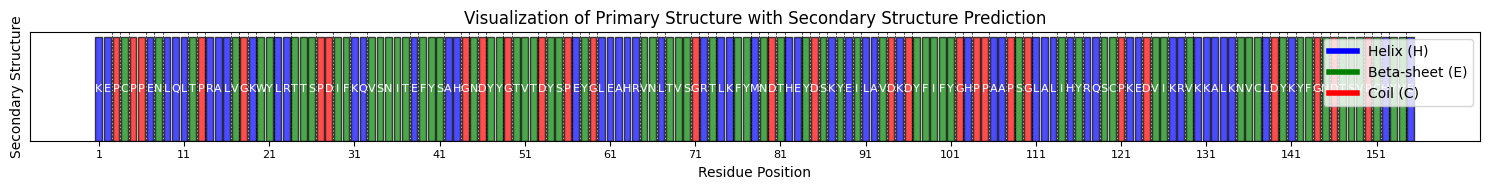

In [7]:
fig, ax = plt.subplots(figsize=(15, 2))
for i, (aa, sec) in enumerate(zip(sequence, secondary_structure)):
    ax.bar(i, 1, color=colors[i], edgecolor='black', alpha=0.7)
    ax.text(i, 0.5, aa, ha='center', va='center', color='white', fontsize=8)

for i in range(1, len(secondary_structure)):
    if secondary_structure[i] != secondary_structure[i - 1]:
        ax.axvline(i - 0.5, color='black', linestyle='--', linewidth=0.5)

ax.set_xticks(range(0, len(sequence), 10))  
ax.set_xticklabels(range(1, len(sequence) + 1, 10), fontsize=8)
ax.set_yticks([])
ax.set_title("Visualization of Primary Structure with Secondary Structure Prediction")
ax.set_xlabel("Residue Position")
ax.set_ylabel("Secondary Structure")
plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='Helix (H)'),
    plt.Line2D([0], [0], color='green', lw=4, label='Beta-sheet (E)'),
    plt.Line2D([0], [0], color='red', lw=4, label='Coil (C)')
], loc='upper right')

plt.tight_layout()
plt.show()


In [8]:
# Chemical properties
hydrophobic_residues = {'A', 'V', 'I', 'L', 'M', 'F', 'W'}
polar_residues = {'S', 'T', 'Y', 'N', 'Q'}
charged_residues = {'R', 'K', 'D', 'E'}
disulfide_formers = {'C'}
aromatic_residues = {'F', 'W', 'Y'}
small_residues = {'A', 'G'}
bulky_residues = {'F', 'W', 'Y', 'R', 'K'}
basic_residues = {'R', 'K', 'H'}
acidic_residues = {'D', 'E'}
aliphatic_residues = {'A', 'V', 'I', 'L'}
hydroxyl_residues = {'S', 'T', 'Y'}
amide_residues = {'N', 'Q'}
ionizable_residues = {'R', 'K', 'H', 'D', 'E', 'C', 'Y'}


In [9]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def initialize_positions(sequence, min_distance=1.0, scale=10):
    """
    Initialize random positions for residues with a minimum distance constraint.
    """
    np.random.seed(42)
    positions = []
    
    for _ in range(len(sequence)):
        for _ in range(1000):  
            candidate = np.random.rand(3) * scale
            if all(np.linalg.norm(candidate - np.array(p)) >= min_distance for p in positions):
                positions.append(candidate)
                break
        else:
            raise ValueError("Failed to place residues with minimum distance constraint.")
    
    return np.array(positions)

positions = initialize_positions(sequence, min_distance=1.5)


In [10]:
def enforce_min_distance(positions, min_distance=1.5, max_iterations=1000):
    """
    Adjust positions to enforce a minimum distance between residues.
    """
    for _ in range(max_iterations):
        distances = squareform(pdist(positions))
        np.fill_diagonal(distances, np.inf)  # Ignore self-distances
        min_dist = distances.min()
        
        if min_dist >= min_distance:
            break
        
        # Find overlapping pair and move one residue
        i, j = np.unravel_index(np.argmin(distances), distances.shape)
        diff = positions[i] - positions[j]
        diff /= np.linalg.norm(diff) + 1e-6  # Normalize direction
        positions[i] += diff * (min_distance - min_dist) / 2
        positions[j] -= diff * (min_distance - min_dist) / 2

    return positions

positions = enforce_min_distance(positions, min_distance=1.5)


In [11]:
# Scaling factors
hydrophobic_adjustment = -0.01  # Smaller inward pull
polar_adjustment = 0.02        # Smaller outward push
charged_noise_range = 0.1      # Smaller random noise
bulky_push = 0.05              # Smaller outward push
small_spread = 0.02            # Smaller outward spread
proline_disruption = 0.1       # Smaller random perturbation for proline

# Apply scaling and perturbations
for i, residue in enumerate(sequence):
    if residue in hydrophobic_residues:
        positions[i] *= (1 + hydrophobic_adjustment)
    elif residue in polar_residues:
        positions[i] *= (1 + polar_adjustment)
    elif residue in charged_residues:
        positions[i] += np.random.uniform(-charged_noise_range, charged_noise_range, 3)
    elif residue in aromatic_residues:
        positions[i] *= (1 + hydrophobic_adjustment * 0.5)
    elif residue in small_residues:
        positions[i] *= (1 + small_spread)
    elif residue in bulky_residues:
        positions[i] *= (1 + bulky_push)
    elif residue in hydroxyl_residues:
        positions[i] *= (1 + polar_adjustment * 0.5)
    elif residue in amide_residues:
        positions[i] *= (1 + polar_adjustment)
    elif residue in ionizable_residues:
        positions[i] += np.random.uniform(-0.1, 0.1, 3)

# Enforce minimum distances after adjustments
positions = enforce_min_distance(positions, min_distance=1.5)

# Normalize positions without compressing distances too much
positions -= positions.mean(axis=0)
positions /= np.linalg.norm(positions, axis=1).max() * 1.2


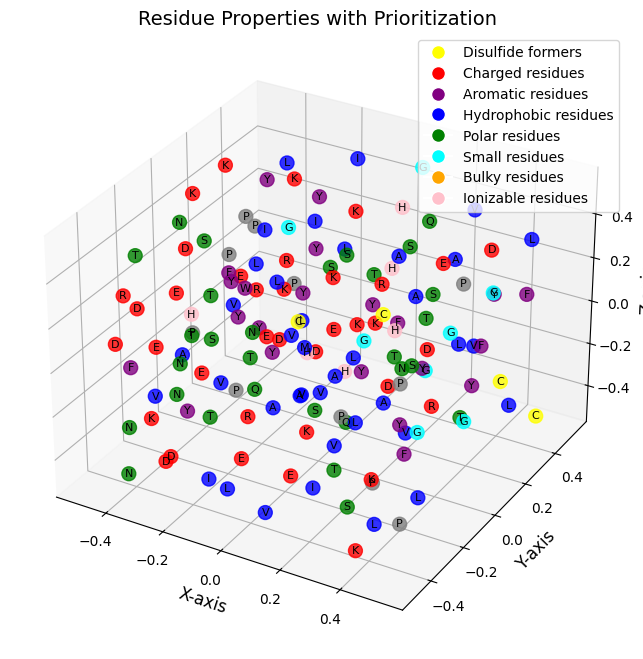

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Priority order of properties
# Higher priority appears first
property_priority = [
    ('disulfide_formers', 'yellow'),
    ('charged_residues', 'red'),
    ('aromatic_residues', 'purple'),
    ('hydrophobic_residues', 'blue'),
    ('polar_residues', 'green'),
    ('small_residues', 'cyan'),
    ('bulky_residues', 'orange'),
    ('ionizable_residues', 'pink'),
]

# Assign colors based on prioritized properties
colors = []
for residue in sequence:
    assigned = False
    for property_name, color in property_priority:
        if residue in globals()[property_name]:
            colors.append(color)
            assigned = True
            break
    if not assigned:
        colors.append('gray')  # Default for uncategorized residues

# Scatter plot
positions = np.array(positions)  # Ensure positions are NumPy array
scatter = ax.scatter(
    positions[:, 0], positions[:, 1], positions[:, 2], c=colors, s=100, alpha=0.8
)

# Annotate residues with all properties
for i, residue in enumerate(sequence):
    ax.text(
        positions[i, 0], positions[i, 1], positions[i, 2],
        residue, fontsize=8, ha='center', va='center'
    )
    
# Aesthetics
ax.set_title("Residue Properties with Prioritization", fontsize=14)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)
ax.set_zlabel("Z-axis", fontsize=12)
ax.grid(True)

# Add legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
    for _, color in property_priority
]
labels = [prop.replace('_', ' ').capitalize() for prop, _ in property_priority]
ax.legend(handles, labels, loc='upper right', fontsize=10)

# Show the plot
plt.show()


In [14]:
def calculate_energy(positions, sequence):
    """
    Refined energy function with controlled repulsion energy and rescaled contributions.
    """
    epsilon = 1e-6  # Small value to prevent division by zero
    energy = 0

    # Scaling factors for interactions
    hydrophobic_scale = 0.1
    electrostatic_scale = 0.05
    repulsion_scale = 0.1

    # Individual energy contributions
    hydrophobic_energy = 0
    electrostatic_energy = 0
    repulsion_energy = 0

    for i, residue1 in enumerate(sequence):
        for j in range(i + 1, len(sequence)):  # Avoid redundant calculations
            residue2 = sequence[j]
            distance = max(np.linalg.norm(positions[i] - positions[j]), 1.2)  # Clamp minimum distance

            # Hydrophobic interactions
            if residue1 in hydrophobic_residues and residue2 in hydrophobic_residues:
                hydrophobic_energy -= hydrophobic_scale / distance

            # Electrostatic interactions
            if (residue1 in {'R', 'K'} and residue2 in {'D', 'E'}) or \
               (residue1 in {'D', 'E'} and residue2 in {'R', 'K'}):
                electrostatic_energy -= electrostatic_scale / distance

            # Repulsive interactions (smoother penalty)
            if distance < 1.5:
                repulsion_energy += repulsion_scale * (1.5 - distance)**2

    # Normalize by the number of residue pairs
    num_pairs = len(sequence) * (len(sequence) - 1) / 2
    energy = (hydrophobic_energy + electrostatic_energy + repulsion_energy) / num_pairs

    # Debugging contributions
    print(f"Hydrophobic Energy: {hydrophobic_energy:.4f}")
    print(f"Electrostatic Energy: {electrostatic_energy:.4f}")
    print(f"Repulsion Energy: {repulsion_energy:.4f}")

    return energy


In [15]:
def optimize_positions(positions, sequence, iterations=1000, learning_rate=0.1):
    epsilon = 1e-6
    hydrophobic_scale = 1.0
    electrostatic_scale = 0.5
    repulsion_scale = 0.01
    momentum = 0.95
    max_update = 0.5  # Clamp maximum position update

    velocity = np.zeros_like(positions)
    previous_energy = None

    for iter in range(iterations):
        gradients = np.zeros_like(positions)

        # Compute gradients
        for i, residue1 in enumerate(sequence):
            for j in range(i + 1, len(sequence)):
                residue2 = sequence[j]
                diff = positions[i] - positions[j]
                distance = np.linalg.norm(diff) + epsilon

                # Hydrophobic interactions
                if residue1 in hydrophobic_residues and residue2 in hydrophobic_residues:
                    gradients[i] -= hydrophobic_scale * (diff / distance**2)

                # Electrostatic interactions
                if (residue1 in {'R', 'K'} and residue2 in {'D', 'E'}) or \
                   (residue1 in {'D', 'E'} and residue2 in {'R', 'K'}):
                    gradients[i] -= electrostatic_scale * (diff / distance**2)

                # Repulsive interactions
                if distance < 1.5:
                    gradients[i] += repulsion_scale * (diff / distance**3)

        # Normalize gradients
        gradients /= np.linalg.norm(gradients, axis=1, keepdims=True) + epsilon

        # Scale down gradient updates
        gradients *= 0.5

        # Apply momentum and update positions
        velocity = momentum * velocity - learning_rate * gradients
        updates = np.clip(velocity, -max_update, max_update)  # Clamp updates
        positions += updates

        # Calculate energy
        current_energy = calculate_energy(positions, sequence)

        # Monitor energy, gradient norm, and position changes
        gradient_norm = np.linalg.norm(gradients)
        position_change = np.linalg.norm(updates, axis=1).max()
        if iter % 100 == 0 or iter == 0:
            print(f"Iteration {iter}: Energy = {current_energy:.4f}, Gradient Norm = {gradient_norm:.4f}, Max Position Change = {position_change:.4f}")

        # Early exit condition
        if gradient_norm < 1e-3 and abs(previous_energy - current_energy) < 1e-3:
            print(f"Converged at iteration {iter}")
            break

        previous_energy = current_energy
        learning_rate *= 0.99  # Decay learning rate

    return positions


In [16]:
# Optimize positions
optimized_positions = optimize_positions(positions, sequence)

Hydrophobic Energy: -82.1834
Electrostatic Energy: -14.2295
Repulsion Energy: 105.8615
Iteration 0: Energy = 0.0008, Gradient Norm = 6.2048, Max Position Change = 0.0500
Hydrophobic Energy: -81.1294
Electrostatic Energy: -14.0861
Repulsion Energy: 103.8654
Hydrophobic Energy: -77.4553
Electrostatic Energy: -13.6048
Repulsion Energy: 98.4369
Hydrophobic Energy: -70.6835
Electrostatic Energy: -12.5446
Repulsion Energy: 89.3445
Hydrophobic Energy: -62.4854
Electrostatic Energy: -11.0540
Repulsion Energy: 70.0879
Hydrophobic Energy: -54.5042
Electrostatic Energy: -9.5358
Repulsion Energy: 46.8757
Hydrophobic Energy: -47.3024
Electrostatic Energy: -8.1231
Repulsion Energy: 33.9919
Hydrophobic Energy: -41.0649
Electrostatic Energy: -6.9264
Repulsion Energy: 28.8929
Hydrophobic Energy: -35.8014
Electrostatic Energy: -5.9296
Repulsion Energy: 26.5689
Hydrophobic Energy: -31.3956
Electrostatic Energy: -5.1060
Repulsion Energy: 24.7190
Hydrophobic Energy: -27.6961
Electrostatic Energy: -4.4367
R

In [17]:
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(positions))
print(f"Min Distance: {distances.min():.4f}")
print(f"Mean Distance: {distances.mean():.4f}")


Min Distance: 0.0000
Mean Distance: 82.2765


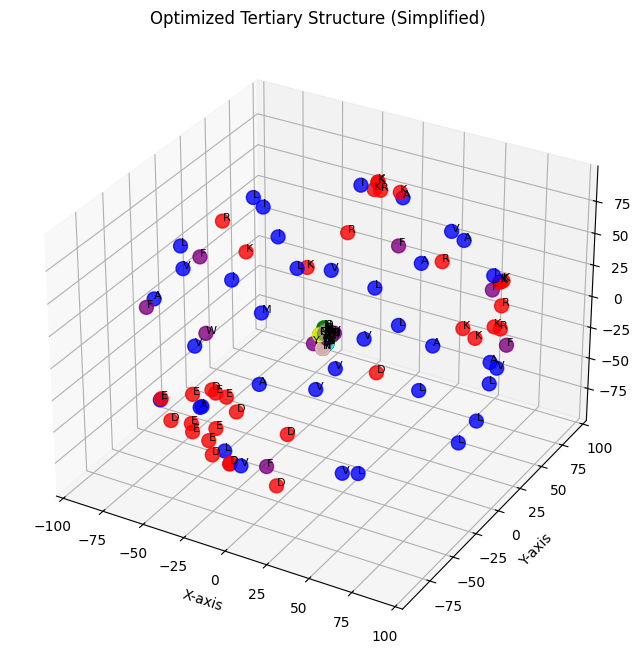

In [18]:

# 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(optimized_positions[:, 0], optimized_positions[:, 1], optimized_positions[:, 2], c=colors, s=100, alpha=0.8)

# Add residue annotations
for i, residue in enumerate(sequence):
    ax.text(optimized_positions[i, 0], optimized_positions[i, 1], optimized_positions[i, 2], residue, fontsize=8)

# Add title and labels
ax.set_title("Optimized Tertiary Structure (Simplified)")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()


In [19]:

aa_to_three_letter = {
        "A": "ALA", "C": "CYS", "D": "ASP", "E": "GLU", "F": "PHE",
        "G": "GLY", "H": "HIS", "I": "ILE", "K": "LYS", "L": "LEU",
        "M": "MET", "N": "ASN", "P": "PRO", "Q": "GLN", "R": "ARG",
        "S": "SER", "T": "THR", "V": "VAL", "W": "TRP", "Y": "TYR"
    }
def export_to_pdb(positions, sequence, output_file="predicted_structure.pdb"):
    with open(output_file, 'w') as pdb_file:
        for i, (x, y, z) in enumerate(positions):
            pdb_file.write(f"ATOM  {i+1:5d}  CA  {sequence[i]:>3} A {i+1:4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00\n")


In [20]:
def extract_coordinates(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coordinates = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    coordinates.append(atom.coord)
    return coordinates

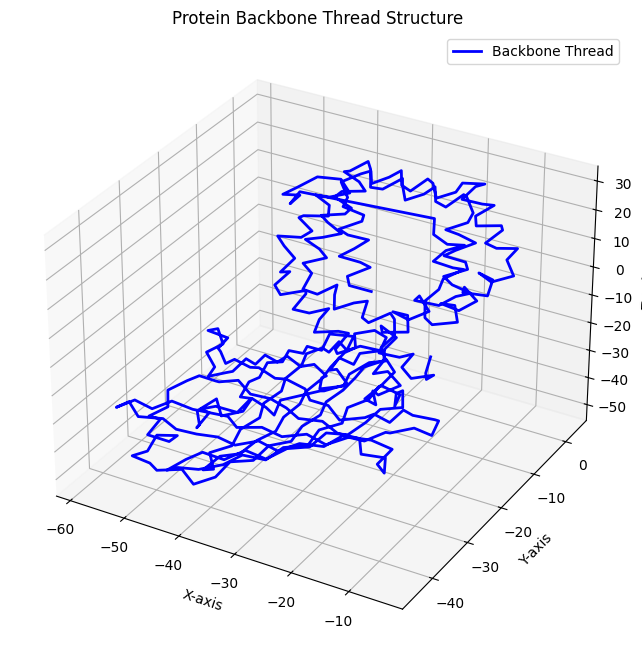

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio.PDB import PDBParser
import numpy as np

# Function to extract coordinates from the PDB file
def extract_coordinates_thread(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                try:
                    # Extract alpha carbon (CA) coordinates only for thread visualization
                    atom = residue['CA']
                    coords.append(atom.coord)
                except KeyError:
                    # Skip residues without a CA atom
                    continue
    return np.array(coords)

# Path to your PDB file
pdb_file_path = r"data\4jrb.pdb"

# Extract alpha-carbon coordinates for thread visualization
thread_coords = extract_coordinates_thread(pdb_file_path)

# Plot the thread structure in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot a line connecting the alpha-carbon atoms
ax.plot(thread_coords[:, 0], thread_coords[:, 1], thread_coords[:, 2], color='blue', linewidth=2, label='Backbone Thread')

# Add labels and title
ax.set_title("Protein Backbone Thread Structure")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.legend()

plt.show()
